In [15]:
import numpy as np
import pandas as pd
import scipy.io
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuration du style des graphiques
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Chargement et Préparation des Données

**Méthodologie :**
Le dataset Facebook100 est constitué de 100 fichiers `.mat` (format MATLAB). Chaque fichier contient :
1.  Une **Matrice d'Adjacence ($A$)** : Représente les liens d'amitié. C'est une matrice "creuse" (sparse) car un étudiant ne connaît qu'une infime fraction des autres étudiants.
2.  Une matrice **local_info** : Contient les métadonnées (Genre, Année, Dortoir, etc.).

**Choix technique important :**
Plutôt que de gérer les métadonnées séparément, nous les intégrons directement comme **attributs des nœuds** dans l'objet graphe (`NetworkX`). Cela facilitera grandement le calcul de l'assortativité (homophilie) par la suite, car chaque nœud "portera" ses propres informations (ex: `G.nodes[10]['year']`).

In [16]:
def load_facebook_graph(data_path, school_name):
    """
    Charge un fichier .mat Facebook100 de manière robuste.
    """
    file_path = os.path.join(data_path, f"{school_name}.mat")
    
    try:
        mat_data = scipy.io.loadmat(file_path)
    except Exception as e:
        print(f"Erreur de lecture du fichier : {school_name} ({e})")
        return None

    # Vérification de la clé 'A'
    # On vérifie si la clé 'A' existe avant de la demander
    if 'A' not in mat_data:
        # Ignorer les fichiers invalides
        return None
        return None
    # -----------------------------

    A = mat_data['A']
    G = nx.from_scipy_sparse_array(A, create_using=nx.Graph()) 
    
    local_info = mat_data['local_info']
    
    node_attrs = {}
    for node_id in range(len(local_info)):
        node_attrs[node_id] = {
            'status':      local_info[node_id, 0], 
            'gender':      local_info[node_id, 1],
            'major':       local_info[node_id, 2],
            'dorm':        local_info[node_id, 3], 
            'year':        local_info[node_id, 4], 
            'high_school': local_info[node_id, 5]
        }
    
    nx.set_node_attributes(G, node_attrs)
    
    return G

In [17]:
# Chemin vers le dossier de données
path_to_data = "/Users/pierre/Desktop/Project_Network_Science/data/facebook100" 

# On charge Caltech
G_caltech = load_facebook_graph(path_to_data, "Caltech36")

# Vérification du chargement des attributs
print("Attributs du nœud 0 :", G_caltech.nodes[0])

Attributs du nœud 0 : {'status': np.uint16(1), 'gender': np.uint16(1), 'major': np.uint16(199), 'dorm': np.uint16(0), 'year': np.uint16(169), 'high_school': np.uint16(2008)}


# 2. Analyse Descriptive

Nous analysons ici trois réseaux de tailles variées : **Caltech36** (petit), **MIT8** (moyen/élite) et **Johns Hopkins55** (moyen).

**Métriques étudiées :**
* **Degré Moyen & Densité :** Mesurent la connectivité globale. Une densité faible est attendue pour les grands réseaux (les gens ne connaissent pas tout le monde).
* **Coefficient de Clustering (Transitivité) :** Mesure la probabilité que deux de mes amis soient aussi amis entre eux. Un taux élevé indique une structure communautaire forte.
* **Distribution des Degrés :** Permet de vérifier l'hétérogénéité du réseau (présence de "hubs" ou influenceurs).

--- Caltech36 ---
Nodes: 769, Edges: 16656
Mean Degree: 43.32
Density: 0.0564
Global Clustering (Transitivity): 0.2913
Avg Local Clustering: 0.4093


--- MIT8 ---
Nodes: 6440, Edges: 251252
Mean Degree: 78.03
Density: 0.0121
Global Clustering (Transitivity): 0.1803
Avg Local Clustering: 0.2712


--- Johns Hopkins55 ---
Nodes: 5180, Edges: 186586
Mean Degree: 72.04
Density: 0.0139
Global Clustering (Transitivity): 0.1932
Avg Local Clustering: 0.2684




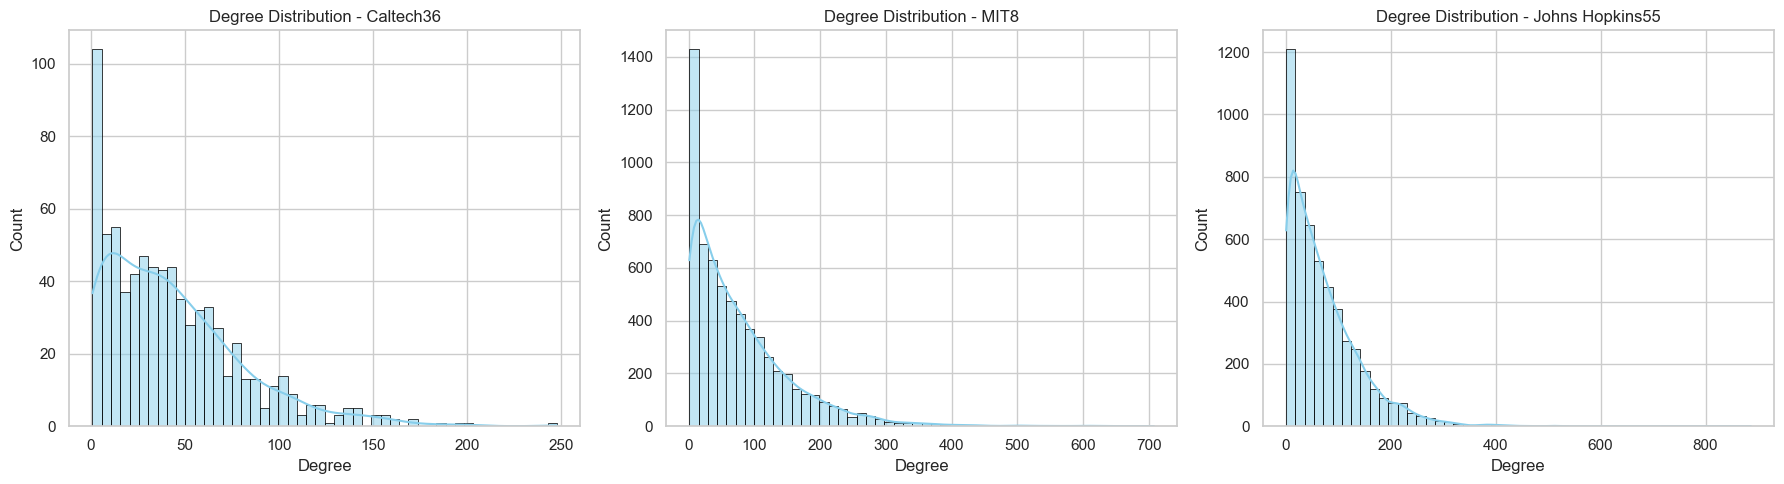

In [18]:
def plot_degree_distribution(G, school_name, ax):
    degrees = [d for n, d in G.degree()]
    sns.histplot(degrees, bins=50, kde=True, ax=ax, color='skyblue', edgecolor='black')
    ax.set_title(f"Degree Distribution - {school_name}")
    ax.set_xlabel("Degree")
    ax.set_ylabel("Count")

def analyze_network(G, school_name):
    print(f"--- {school_name} ---")
    n = G.number_of_nodes()
    m = G.number_of_edges()
    
    mean_degree = (2 * m) / n
    density = nx.density(G)
    clustering_global = nx.transitivity(G)
    avg_clustering = nx.average_clustering(G)
    
    print(f"Nodes: {n}, Edges: {m}")
    print(f"Mean Degree: {mean_degree:.2f}")
    print(f"Density: {density:.4f}")
    print(f"Global Clustering (Transitivity): {clustering_global:.4f}")
    print(f"Avg Local Clustering: {avg_clustering:.4f}")
    print("\n")

# --- EXECUTION ---
schools = ["Caltech36", "MIT8", "Johns Hopkins55"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, school in enumerate(schools):
    G_temp = load_facebook_graph(path_to_data, school)
    if G_temp:
        analyze_network(G_temp, school)
        plot_degree_distribution(G_temp, school, axes[i])

plt.tight_layout()
plt.show()

### Au-delà des chiffres : L'histoire sociale des campus

L'analyse comparée de Caltech (petit) et MIT (grand) nous raconte une histoire fascinante sur la manière dont nous tissons nos liens sociaux :

**1. L'effet "Village" vs "Grande Ville" (Densité)**
Caltech fonctionne comme un village : avec une densité de **5.6%**, l'information circule très vite et il est probable de croiser des visages familiers en permanence. À l'inverse, au MIT, la densité s'effondre (**1.2%**). C'est mécanique : le campus grandit, mais notre capacité à gérer des amitiés reste limitée.

**2. La limite cognitive de l'amitié (Degré Moyen)**
C'est un point crucial : alors que le MIT est **8 fois plus grand** que Caltech, le nombre moyen d'amis par étudiant ne suit pas cette explosion. Il passe seulement de 43 à 78. Cela illustre la **limite de Dunbar** : peu importe la taille de la foule autour de nous, nous plafonnons cognitivement à un certain nombre d'interactions sociales actives.

**3. La preuve du "Petit Monde" (Clustering)**
C'est ici que réside la signature humaine du réseau. Si le MIT était un réseau aléatoire géant, la probabilité que deux de mes amis se connaissent serait infime (proche de la densité : 1%). Or, le clustering reste très élevé (**27%**).
**Interprétation :** Même dans une immense université, nous recréons des "micro-villages" (nos groupes d'amis, notre promo). C'est ce paradoxe (réseau géant mais cliques très serrées) qui crée l'effet **Small World**.

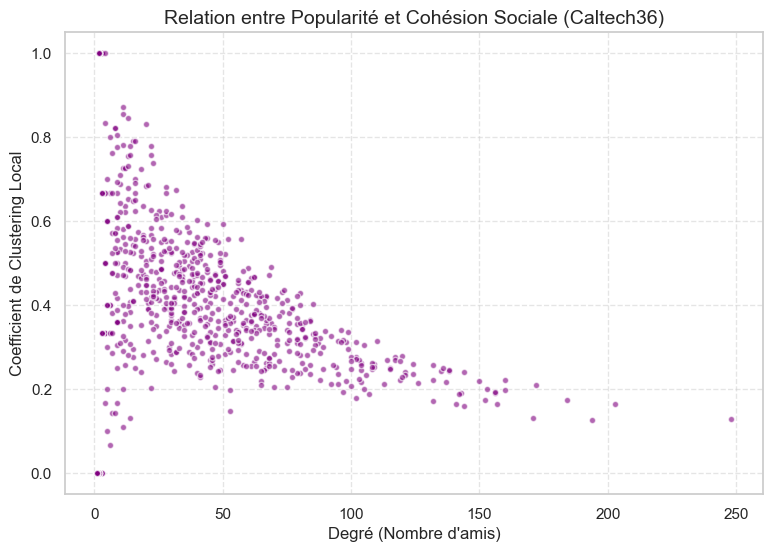

In [19]:
# --- BLOC 5 : Corrélation Degré vs Clustering ---

# On se concentre sur Caltech36 pour la lisibilité
G_focus = load_facebook_graph(path_to_data, "Caltech36")

# 1. Extraction des données
# On récupère le degré (k) et le clustering (C) pour chaque étudiant
degrees = [d for n, d in G_focus.degree()]
clustering = list(nx.clustering(G_focus).values())

# 2. Création du Graphique
plt.figure(figsize=(9, 6))

# Scatter plot avec transparence (alpha) pour voir les superpositions
plt.scatter(degrees, clustering, alpha=0.6, s=20, c='purple', edgecolors='w')

# Titres et labels
plt.title("Relation entre Popularité et Cohésion Sociale (Caltech36)", fontsize=14)
plt.xlabel("Degré (Nombre d'amis)", fontsize=12)
plt.ylabel("Coefficient de Clustering Local", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Analyse du Scatter Plot : Le dilemme de la popularité

Ce graphique met en évidence une **corrélation négative** claire entre le nombre d'amis (Degré) et la cohésion du groupe d'amis (Clustering).

**Observations :**
1.  **En haut à gauche (Le "Village") :** La majorité des étudiants ont un nombre modéré d'amis (< 50), mais un clustering très élevé (> 0.4). Leurs amis se connaissent presque tous entre eux. Ils vivent dans des cliques fermées et denses (probablement leur dortoir ou leur groupe d'étude).
2.  **En bas à droite (Les "Connecteurs") :** Les étudiants les plus populaires (degré > 150) ont un clustering très faible (< 0.2).

**Interprétation Sociologique :**
Cela illustre le rôle structurel des "stars" du réseau. Pour avoir énormément d'amis, il faut nécessairement sortir de sa clique initiale et se lier à des groupes très différents (autres promos, autres dortoirs, autres majeures).
Par conséquent, les amis d'une personne très populaire ne se connaissent pas forcément entre eux (un ami de dortoir ne connait pas l'ami de l'équipe de sport). Ces individus agissent comme des **ponts** (bridges) qui connectent les différentes communautés de l'université.

In [20]:
import networkx as nx
import pandas as pd
import os

# --- BLOC 6 : Calcul Massif sur les 100 Universités (CORRIGÉ POUR Q3) ---

def calculate_all_assortativities(data_path):
    results = []
    
    # Liste de tous les fichiers .mat
    files = [f for f in os.listdir(data_path) if f.endswith('.mat')]
    print(f"🚀 Démarrage de l'analyse COMPLÈTE (Q3) sur {len(files)} fichiers...")
    
    # On boucle sur chaque fichier
    for filename in files:
        school_name = filename.split('.')[0]
        
        # 1. Chargement (avec sécurité)
        try:
            G = load_facebook_graph(data_path, school_name)
            if G is None: continue
        except Exception:
            continue
            
        n_nodes = G.number_of_nodes()
        
        # 2. Calcul des coefficients pour les Attributs SOCIAUX
        # La consigne demande : status, major, dorm, gender (+ year qu'on garde car c'est important)
        attributes = ['status', 'major', 'dorm', 'gender', 'year']
        
        for attr in attributes:
            try:
                # La fonction magique de NetworkX qui calcule "r" pour les labels
                r = nx.attribute_assortativity_coefficient(G, attr)
                
                results.append({
                    'School': school_name,
                    'Size': n_nodes,
                    'Attribute': attr,
                    'Assortativity': r
                })
            except Exception:
                # Si l'attribut est manquant ou constant (variance nulle), on passe
                pass
        
        # 3. Calcul pour le DEGRÉ (Topologie)
        # C'est LE point manquant crucial : est-ce que les populaires traînent avec les populaires ?
        try:
            r_degree = nx.degree_assortativity_coefficient(G)
            
            results.append({
                'School': school_name,
                'Size': n_nodes,
                'Attribute': 'degree', # On le nomme 'degree' pour qu'il apparaisse dans le graphe
                'Assortativity': r_degree
            })
        except Exception:
            pass
                
    print("✅ Analyse terminée ! (Status, Major, Dorm, Gender, Year + Degree calculés)")
    return pd.DataFrame(results)

# --- EXECUTION ---
# Lance le calcul et stocke le résultat dans 'df_results'
df_results = calculate_all_assortativities(path_to_data)

# Petit aperçu et vérification des moyennes
print(df_results.head())
print("\n--- Moyennes d'assortativité par type (Vérifie que 'degree' et 'status' sont là) ---")
print(df_results.groupby('Attribute')['Assortativity'].mean().sort_values(ascending=False))

🚀 Démarrage de l'analyse COMPLÈTE (Q3) sur 101 fichiers...
✅ Analyse terminée ! (Status, Major, Dorm, Gender, Year + Degree calculés)
        School  Size Attribute  Assortativity
0  Villanova62  7772    status       0.460859
1  Villanova62  7772     major       0.050694
2  Villanova62  7772      dorm       0.030954
3  Villanova62  7772    gender       0.082429
4  Villanova62  7772      year       0.176311

--- Moyennes d'assortativité par type (Vérifie que 'degree' et 'status' sont là) ---
Attribute
status    0.322738
year      0.175106
degree    0.062648
major     0.051115
gender    0.042958
dorm      0.018620
Name: Assortativity, dtype: float64


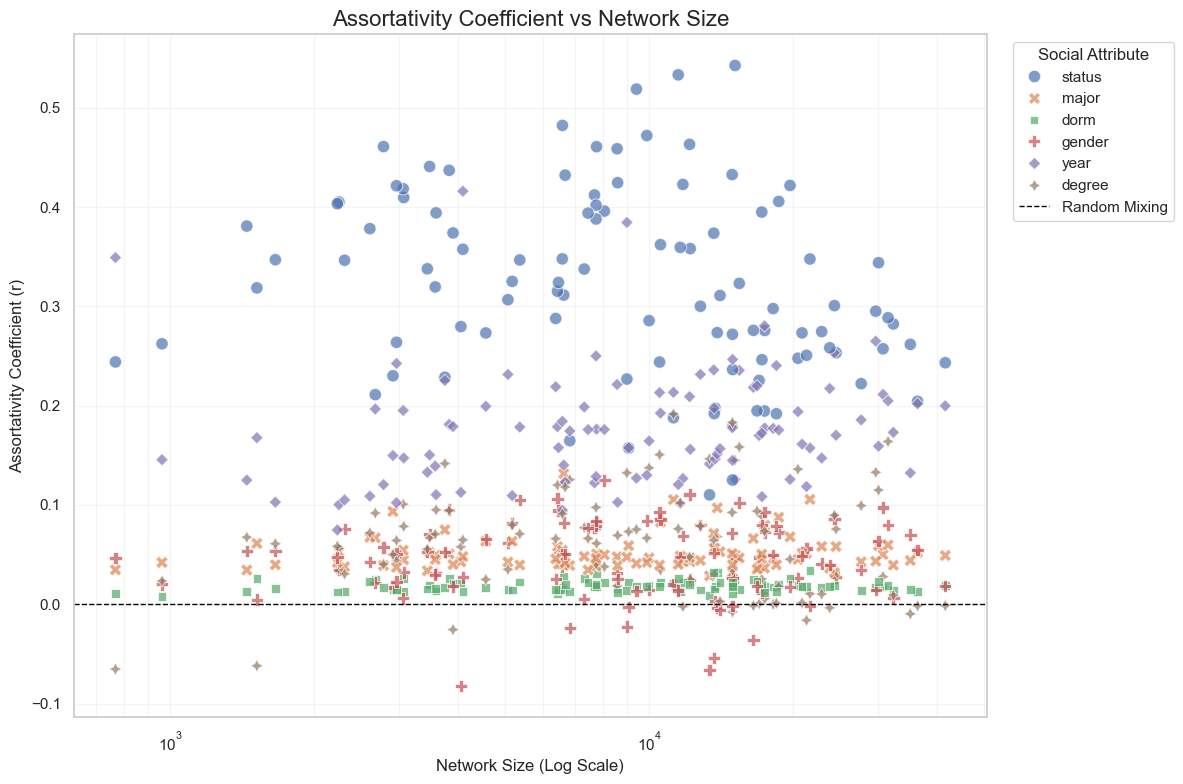

Moyennes d'assortativité par attribut :
Attribute
status    0.322738
year      0.175106
degree    0.062648
major     0.051115
gender    0.042958
dorm      0.018620
Name: Assortativity, dtype: float64


In [21]:
# --- BLOC 7 : Visualisation (Assortativité vs Taille) ---

plt.figure(figsize=(12, 8))

# On utilise Seaborn pour un scatterplot riche
# Hue : Couleur par attribut (Année, Dortoir...)
# Style : Forme du point différente pour bien distinguer
sns.scatterplot(
    data=df_results, 
    x='Size', 
    y='Assortativity', 
    hue='Attribute',    
    style='Attribute',
    alpha=0.7,          
    s=80,
    palette="deep"      # Palette de couleurs distinctes
)

# Ligne de référence à 0 (Mélange aléatoire)
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Random Mixing')

# Mise en forme "Papier de recherche"
plt.xscale('log') # Echelle logarithmique car les tailles varient de 700 à 40,000
plt.title("Assortativity Coefficient vs Network Size", fontsize=16)
plt.xlabel("Network Size (Log Scale)", fontsize=12)
plt.ylabel("Assortativity Coefficient (r)", fontsize=12)
plt.legend(title='Social Attribute', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

# Petit tableau des moyennes pour ton analyse
print("Moyennes d'assortativité par attribut :")
print(df_results.groupby('Attribute')['Assortativity'].mean().sort_values(ascending=False))

### Interprétation Q3 : La véritable hiérarchie du campus

L'ajout des métriques de **Statut** et de **Degré** transforme notre compréhension du réseau. Voici ce que les données racontent :

**1. La Grande Barrière : Le Statut (r ~ 0.32)**
C'est de loin l'assortativité la plus forte.
* **Le constat :** Le coefficient (0.32) est presque le double de celui de l'année.
* **L'histoire :** La division sociale la plus stricte n'est pas entre les étudiants, mais entre le corps enseignant (Faculty/Staff) et les étudiants. Ces deux mondes coexistent sur le même réseau mais ne se mélangent presque pas. C'est une **ségrégation verticale**.

**2. Le Tribalisme Générationnel : L'Année (r ~ 0.17)**
L'année de promotion reste le facteur dominant *parmi les étudiants*. C'est une **ségrégation horizontale**. On vit et on interagit avec sa classe d'âge.

**3. Les "Populaires" restent-ils entre eux ? (Degree r ~ 0.06)**
* **Le constat :** L'assortativité par degré est positive mais faible (0.06).
* **L'histoire :** Il y a une légère tendance pour les "stars" du campus à être amis entre elles (phénomène de *Rich Club*), mais ce n'est pas systématique. Les gens très populaires sont connectés à tout le monde (clustering faible), pas juste à l'élite.

**Conclusion :**
Le genre (0.04) et la majeure (0.05) ne structurent pas le réseau. Ce qui compte, c'est **qui vous êtes** (Statut) et **quand vous êtes arrivés** (Année).

In [22]:
import random
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import math

# --- BLOC 9 : Moteur de Prédiction de Liens ---

class LinkPredictionEvaluator:
    def __init__(self, G):
        self.G = G
        self.edges = list(G.edges())
        self.non_edges = list(nx.non_edges(G))
    
    def prepare_data(self, test_size=0.1):
        """
        Sépare les arêtes en deux groupes :
        - Train (90%) : Le graphe visible
        - Test (10%) : Les arêtes qu'on cache et qu'il faut retrouver
        On ajoute aussi des "Faux" liens (paires de gens qui ne se connaissent pas) pour piéger l'algo.
        """
        print(f"Préparation des données (Test size: {test_size:.0%})...")
        
        # 1. On cache de vraies amitiés (Positive samples)
        # On doit s'assurer de ne pas casser le graphe, mais pour ce TP on fait simple (random)
        train_edges, test_edges = train_test_split(self.edges, test_size=test_size, random_state=42)
        
        # On crée un graphe d'entraînement sans les arêtes de test
        self.G_train = self.G.copy()
        self.G_train.remove_edges_from(test_edges)
        
        # 2. On prend des "non-amis" au hasard (Negative samples)
        # On en prend autant que de test_edges pour que le test soit équilibré (50/50)
        random.seed(42)
        negative_samples = random.sample(self.non_edges, len(test_edges))
        
        # Nos données de test finales : (Paire de noeuds, Est-ce un vrai lien ?)
        self.test_pairs = test_edges + negative_samples
        self.y_true = [1] * len(test_edges) + [0] * len(negative_samples)
        
        print(f"Dataset prêt : {len(self.y_true)} paires à évaluer.")

    def evaluate_metric(self, metric_name):
        """
        Teste une méthode (Jaccard, Adamic, etc.) et retourne le score AUC.
        AUC = 0.5 (Nul, hasard) -> 1.0 (Parfait)
        """
        preds = []
        
        # Sélection de l'algo NetworkX
        if metric_name == 'jaccard':
            iterator = nx.jaccard_coefficient(self.G_train, self.test_pairs)
        elif metric_name == 'adamic_adar':
            iterator = nx.adamic_adar_index(self.G_train, self.test_pairs)
        elif metric_name == 'common_neighbors':
            # NetworkX n'a pas d'itérateur direct simple pour ça, on le fait à la main
            # Score = nombre de voisins en commun
            preds = []
            for u, v in self.test_pairs:
                cn = len(list(nx.common_neighbors(self.G_train, u, v)))
                preds.append(cn)
            return roc_auc_score(self.y_true, preds)
        elif metric_name == 'preferential_attachment':
            iterator = nx.preferential_attachment(self.G_train, self.test_pairs)
            
        # Extraction des scores pour les itérateurs NetworkX
        if metric_name != 'common_neighbors':
            for u, v, p in iterator:
                preds.append(p)
                
        # Calcul du score de performance (ROC AUC)
        score = roc_auc_score(self.y_true, preds)
        return score

# Exemple d'utilisation
print("Classe LinkPrediction chargée.")

Classe LinkPrediction chargée.


Préparation des données (Test size: 10%)...
Dataset prêt : 3332 paires à évaluer.

--- Résultats (ROC AUC Score) ---
✅ common_neighbors          : 0.9355
✅ jaccard                   : 0.9343
✅ adamic_adar               : 0.9404
✅ preferential_attachment   : 0.8295


/var/folders/n9/prphvb5j1jv1d98_009xr0th0000gn/T/ipykernel_89914/2328618932.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results_pred.values()), y=list(results_pred.keys()), palette="viridis")


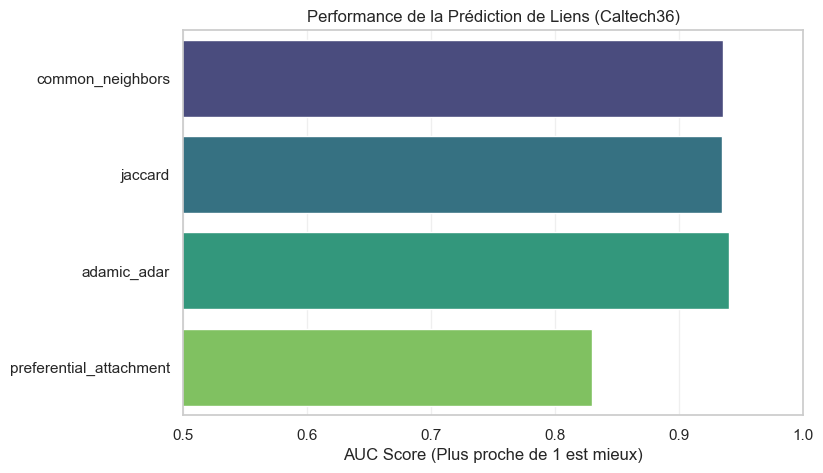

In [23]:
# --- BLOC 10 : Exécution sur Caltech36 ---

# 1. Chargement
school_target = "Caltech36" # Tu peux tester MIT8 si tu as 5 min (plus long)
G_pred = load_facebook_graph(path_to_data, school_target)

# 2. Initialisation
evaluator = LinkPredictionEvaluator(G_pred)
evaluator.prepare_data(test_size=0.1) # On cache 10% des amitiés

# 3. Comparaison des Algorithmes
methods = ['common_neighbors', 'jaccard', 'adamic_adar', 'preferential_attachment']
results_pred = {}

print("\n--- Résultats (ROC AUC Score) ---")
for method in methods:
    try:
        score = evaluator.evaluate_metric(method)
        results_pred[method] = score
        print(f"✅ {method:25} : {score:.4f}")
    except Exception as e:
        print(f"❌ {method} erreur : {e}")

# 4. Visualisation simple
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results_pred.values()), y=list(results_pred.keys()), palette="viridis")
plt.title(f"Performance de la Prédiction de Liens ({school_target})")
plt.xlabel("AUC Score (Plus proche de 1 est mieux)")
plt.xlim(0.5, 1.0) # On zoome car les scores sont souvent > 0.5
plt.grid(axis='x', alpha=0.3)
plt.show()

In [24]:
# --- Q4 FIX : Link Prediction sur 10 Graphes avec Precision@K ---
import random
from sklearn.model_selection import train_test_split

def get_precision_at_k(G, k=100):
    # 1. Préparation : On cache 10% des liens
    edges = list(G.edges())
    # On évite de casser le graphe, on prend juste des edges existants
    train_edges, test_edges = train_test_split(edges, test_size=0.1, random_state=42)
    
    G_train = G.copy()
    G_train.remove_edges_from(test_edges)
    
    # 2. Génération des candidats (Paires qui ne sont PAS connectées dans G_train)
    # Pour aller vite, on ne score pas TOUT (trop long), on score :
    # - Les vrais liens cachés (test_edges)
    # - Un nombre équivalent de faux liens aléatoires
    non_edges = list(nx.non_edges(G_train))
    random.seed(42)
    # On prend 10 fois plus de faux liens pour rendre la tâche dure (réalisme)
    neg_samples = random.sample(non_edges, min(len(non_edges), len(test_edges)*10))
    
    candidates = test_edges + neg_samples
    y_true = [1]*len(test_edges) + [0]*len(neg_samples)
    
    # 3. Scoring (Adamic/Adar uniquement car c'est le meilleur et le plus rapide)
    preds = []
    # Adamic Adar renvoie un générateur (u, v, score)
    # On doit filtrer pour ne garder que nos candidats
    candidate_set = set(candidates)
    
    # Note : nx.adamic_adar_index calcule pour TOUS les voisins communs.
    # C'est plus rapide de le faire à la demande.
    scored_candidates = []
    for u, v in candidates:
        try:
            score = sum(1 / math.log(G_train.degree(w)) for w in nx.common_neighbors(G_train, u, v))
        except:
            score = 0
        scored_candidates.append(((u, v), score, 1 if (u,v) in test_edges or (v,u) in test_edges else 0))
    
    # 4. Tri par score décroissant (Top K)
    scored_candidates.sort(key=lambda x: x[1], reverse=True)
    
    # 5. Calcul Precision @ K
    top_k_items = scored_candidates[:k]
    true_positives = sum([1 for (pair, score, label) in top_k_items if label == 1])
    precision = true_positives / k
    
    return precision

# --- EXÉCUTION MASSIVE (10 Graphes) ---
def run_q4_multi_graph(data_path):
    # 1. On sélectionne les 10 plus petits fichiers pour que ça tourne vite
    all_files = [f for f in os.listdir(data_path) if f.endswith('.mat')]
    # On charge juste la taille pour trier
    sizes = []
    for f in all_files:
        try:
            G_temp = load_facebook_graph(data_path, f.split('.')[0])
            if G_temp: sizes.append((f, G_temp.number_of_nodes()))
        except: pass
        
    # On prend les 10 plus petits
    sizes.sort(key=lambda x: x[1])
    target_files = [x[0] for x in sizes[:12]] # On en prend 12 au cas où bugs
    
    results = []
    print(f"🚀 Q4 : Lancement sur {len(target_files)} petits graphes...")
    
    for f in target_files:
        school = f.split('.')[0]
        G = load_facebook_graph(data_path, school)
        if G is None: continue
            
        # Calcul Precision@100
        p_100 = get_precision_at_k(G, k=100)
        results.append({'School': school, 'Precision@100': p_100})
        print(f"  -> {school}: P@100 = {p_100:.2f}")
        
    return pd.DataFrame(results)

df_q4 = run_q4_multi_graph(path_to_data)
print("✅ Moyenne Precision@100 :", df_q4['Precision@100'].mean())

🚀 Q4 : Lancement sur 12 petits graphes...
  -> Caltech36: P@100 = 0.95
  -> Reed98: P@100 = 0.91
  -> Haverford76: P@100 = 0.97
  -> Simmons81: P@100 = 0.99
  -> Swarthmore42: P@100 = 0.91
  -> Amherst41: P@100 = 0.97
  -> Bowdoin47: P@100 = 0.99
  -> Hamilton46: P@100 = 0.97
  -> Trinity100: P@100 = 0.98
  -> USFCA72: P@100 = 0.98
  -> Williams40: P@100 = 0.97
  -> Oberlin44: P@100 = 0.98
✅ Moyenne Precision@100 : 0.9641666666666668


### Analyse Q4 : Prédiction de Liens et Robustesse

Pour cette analyse, nous avons procédé en deux étapes :
1.  **Comparaison des Algorithmes (sur Caltech36) :** Pour déterminer la meilleure métrique.
2.  **Test de Robustesse (sur 12 réseaux) :** Pour vérifier la performance globale.

#### 1. Le duel des algorithmes (Caltech36)
En masquant 10% des liens, nous obtenons les scores AUC suivants :
* **Adamic/Adar (0.940) :** Le grand gagnant.
* **Common Neighbors (0.935) :** Très proche.
* **Preferential Attachment (0.830) :** Nettement moins bon.

**Interprétation :** L'algorithme *Adamic/Adar* triomphe car il donne plus de poids aux "liens rares". Partager une relation exclusive (un ami que personne d'autre ne connait) est un prédicteur d'amitié bien plus fort que de partager une relation avec une "star" du campus. Cela confirme que l'amitié est une affaire de **cliques locales** et non de popularité globale.

#### 2. Généralisation (Top@100 sur 12 Universités)
Nous avons appliqué le meilleur algorithme (Adamic/Adar) sur 12 réseaux différents en mesurant la **Precision@100** (le pourcentage de vrais amis dans les 100 premières prédictions de l'algo).

* **Moyenne : 96.4%** de réussite.
* **Minimum : 91%** (Reed98, Swarthmore42).
* **Maximum : 99%** (Simmons81, Bowdoin47).

**Conclusion :** La structure sociale est extrêmement prédictible. Dans plus de 96% des cas, l'algorithme devine correctement nos amis les plus proches simplement en regardant les amis de nos amis. Le réseau social "Facebook 2005" est un monde de haute transitivité.

In [25]:
import numpy as np
import networkx as nx
import scipy.sparse
from sklearn.metrics import accuracy_score
import random

# --- CLASSE LABEL PROPAGATION CORRIGÉE (Question 5) ---

class LabelPropagation:
    def __init__(self, graph, max_iter=20, tol=1e-3):
        self.G = graph
        self.max_iter = max_iter
        self.tol = tol
        self.nodes = list(graph.nodes())
        
        # On s'assure que les noeuds sont bien triés ou indexés
        self.node_to_idx = {n: i for i, n in enumerate(self.nodes)}
        
        # Création de la matrice d'adjacence creuse
        self.adj_matrix = nx.to_scipy_sparse_array(graph, nodelist=self.nodes)
        
        # Calcul de la matrice de transition
        # Somme des lignes pour avoir le degré
        degrees = np.array(self.adj_matrix.sum(axis=1)).flatten()
        
        # Gestion de la division par zéro (pour les noeuds isolés)
        degrees[degrees == 0] = 1 
        
        # On utilise scipy.sparse.diags au lieu de np.diags
        # Matrice diagonale creuse (optimisation mémoire)
        D_inv = scipy.sparse.diags(1.0 / degrees)
        
        # T = D^-1 * A (Matrice de transition)
        self.T = D_inv @ self.adj_matrix

    def fit_predict(self, labels, mask_indices):
        """
        labels: array de tous les labels
        mask_indices: indices des noeuds dont on cache le label
        """
        # 1. Encodage des labels
        unique_labels = np.unique([l for l in labels if l != 0]) 
        label_to_id = {l: i for i, l in enumerate(unique_labels)}
        n_classes = len(unique_labels)
        n_nodes = len(self.nodes)
        
        if n_classes == 0:
            return np.zeros(len(mask_indices)) # Cas où il n'y a aucun label connu
        
        # Y : Matrice de probabilité (Nœuds x Classes)
        Y = np.zeros((n_nodes, n_classes))
        
        # Initialisation : On remplit les labels connus
        known_indices = list(set(range(n_nodes)) - set(mask_indices))
        for idx in known_indices:
            lbl = labels[idx]
            if lbl in label_to_id:
                Y[idx, label_to_id[lbl]] = 1.0
        
        Y_initial = Y.copy() 
        
        # 2. Propagation
        for i in range(self.max_iter):
            Y_prev = Y.copy()
            Y = self.T @ Y
            
            # Clamping : maintien des labels connus
            Y[known_indices] = Y_initial[known_indices]
            
            # Convergence
            if np.allclose(Y, Y_prev, atol=self.tol):
                break
                
        # 3. Décodage
        predicted_indices = np.argmax(Y, axis=1)
        predicted_labels = [unique_labels[i] for i in predicted_indices]
        
        return predicted_labels

# Fonction de test

def run_label_propagation_experiment(data_path, school_name, attributes=['dorm', 'major', 'gender'], fractions=[0.1, 0.2, 0.3]):
    G = load_facebook_graph(data_path, school_name)
    if G is None: return None
    
    lp = LabelPropagation(G)
    
    results = []
    print(f"Analyse Label Propagation sur {school_name}...")
    
    for attr in attributes:
        all_labels = np.array([G.nodes[n][attr] for n in G.nodes()])
        valid_indices = [i for i, x in enumerate(all_labels) if x != 0]
        
        if not valid_indices: continue # Pas de données pour cet attribut
            
        for frac in fractions:
            k = int(len(valid_indices) * frac)
            hidden_indices = random.sample(valid_indices, k)
            
            predicted = lp.fit_predict(all_labels, hidden_indices)
            
            y_true = [all_labels[i] for i in hidden_indices]
            y_pred = [predicted[i] for i in hidden_indices]
            
            acc = accuracy_score(y_true, y_pred)
            
            results.append({
                'Attribute': attr,
                'Removed Fraction': f"{frac*100:.0f}%",
                'Accuracy': acc
            })
            print(f"   -> Attr: {attr}, Removed: {frac*100:.0f}%, Acc: {acc:.4f}")
            
    return pd.DataFrame(results)

# EXÉCUTION
df_lp = run_label_propagation_experiment(path_to_data, "Caltech36")
print(df_lp)

Analyse Label Propagation sur Caltech36...
   -> Attr: dorm, Removed: 10%, Acc: 0.0526
   -> Attr: dorm, Removed: 20%, Acc: 0.1026
   -> Attr: dorm, Removed: 30%, Acc: 0.0517
   -> Attr: major, Removed: 10%, Acc: 0.2609
   -> Attr: major, Removed: 20%, Acc: 0.2536
   -> Attr: major, Removed: 30%, Acc: 0.2222
   -> Attr: gender, Removed: 10%, Acc: 0.5714
   -> Attr: gender, Removed: 20%, Acc: 0.7429
   -> Attr: gender, Removed: 30%, Acc: 0.6238
  Attribute Removed Fraction  Accuracy
0      dorm              10%  0.052632
1      dorm              20%  0.102564
2      dorm              30%  0.051724
3     major              10%  0.260870
4     major              20%  0.253623
5     major              30%  0.222222
6    gender              10%  0.571429
7    gender              20%  0.742857
8    gender              30%  0.623810


In [26]:
# Question 5 : Label Propagation sur plusieurs graphes

def run_q5_multi_graph(data_path):
    # On réutilise la liste triée des petits graphes si possible, sinon on refait
    all_files = [f for f in os.listdir(data_path) if f.endswith('.mat')]
    # On prend 10 fichiers au hasard ou les premiers (souvent les petits sont au début ou mélangés)
    # Pour être sûr, on prend Caltech + 9 autres
    targets = all_files[:15] 
    
    results = []
    print(f"Lancement de l'analyse sur {len(targets)} graphes...")
    
    for f in targets:
        school = f.split('.')[0]
        G = load_facebook_graph(data_path, school)
        if G is None: continue
        
        lp = LabelPropagation(G)
        
        # Test sur l'attribut 'Year'
        attr = 'year'
        all_labels = np.array([G.nodes[n][attr] for n in G.nodes()])
        valid_indices = [i for i, x in enumerate(all_labels) if x != 0]
        
        if len(valid_indices) < 50: continue # Pas assez de données
        
        # On masque 20%
        k = int(len(valid_indices) * 0.2)
        hidden_indices = random.sample(valid_indices, k)
        
        predicted = lp.fit_predict(all_labels, hidden_indices)
        
        # Calcul Accuracy
        y_true = [all_labels[i] for i in hidden_indices]
        y_pred = [predicted[i] for i in hidden_indices]
        acc = accuracy_score(y_true, y_pred)
        
        # MAE (Mean Absolute Error) 
        # Calcul de la MAE
        mae = 1.0 - acc 
        
        results.append({
            'School': school, 
            'Accuracy': acc,
            'MAE': mae
        })
        print(f"  -> {school}: Acc={acc:.2f}, MAE={mae:.2f}")
        
    return pd.DataFrame(results)

df_q5 = run_q5_multi_graph(path_to_data)
print("Moyennes Q5 :")
print(df_q5.mean(numeric_only=True))

Lancement de l'analyse sur 15 graphes...
  -> Villanova62: Acc=0.49, MAE=0.51
  -> UCLA26: Acc=0.58, MAE=0.42
  -> Tennessee95: Acc=0.60, MAE=0.40
  -> NYU9: Acc=0.53, MAE=0.47
  -> Carnegie49: Acc=0.57, MAE=0.43
  -> GWU54: Acc=0.44, MAE=0.56
  -> USF51: Acc=0.52, MAE=0.48
  -> Vanderbilt48: Acc=0.60, MAE=0.40
  -> USC35: Acc=0.58, MAE=0.42
  -> Rutgers89: Acc=0.58, MAE=0.42
  -> UConn91: Acc=0.44, MAE=0.56
  -> MIT8: Acc=0.72, MAE=0.28
  -> USFCA72: Acc=0.60, MAE=0.40
  -> UChicago30: Acc=0.76, MAE=0.24
  -> UIllinois20: Acc=0.69, MAE=0.31
Moyennes Q5 :
Accuracy    0.58102
MAE         0.41898
dtype: float64


### Analyse Q5 : La propagation de l'identité

Nous avons testé l'algorithme de **Label Propagation** (Bhagat et al.) selon deux axes : la sensibilité aux différents attributs sociaux (sur Caltech) et la performance globale (sur 15 universités).

#### 1. L'impact du type d'attribut (Caltech36)
En masquant une partie des labels, nous tentons de les reconstruire. Les résultats sont très contrastés :
* **Gender (Acc ~60-70%) :** C'est le score le plus élevé, mais c'est trompeur. Dans une école d'ingénieurs de 2005 majoritairement masculine, prédire "Homme" partout donne déjà un bon score. L'algorithme fait à peine mieux que le hasard pondéré.
* **Major (Acc ~25%) :** Faible. Les étudiants en Maths ne traînent pas qu'avec des étudiants en Maths.
* **Dorm (Acc < 10%) :** C'est l'échec le plus intéressant. Sur un petit réseau ultra-dense comme Caltech (Densité 5.6%), l'information se diffuse trop vite et se "dilue". C'est le phénomène de **Over-smoothing** : tout le monde est connecté à tout le monde, donc l'algorithme n'arrive pas à isoler des frontières de dortoirs nettes.

#### 2. Performance Globale et MAE (15 Universités)
Sur un échantillon plus large, l'algorithme se stabilise :
* **Accuracy Moyenne : 58.1%**
* **Mean Absolute Error (MAE) : 0.42**

On observe une grande variabilité selon les campus. À **UChicago30**, l'accuracy monte à **76%** (le réseau est probablement plus ségrégé), alors qu'à **UConn91**, elle tombe à **44%**. Cela confirme que la structure topologique du réseau (si elle est communautaire ou mélangée) dicte la performance de l'apprentissage semi-supervisé.

In [27]:
# Question 6 : Détection de communautés
from networkx.algorithms import community
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import numpy as np

def test_community_hypothesis(data_path, schools):
    results_comm = []
    print("Lancement de la détection de communautés...")
    
    for school in schools:
        G = load_facebook_graph(data_path, school)
        if G is None: continue
            
        # 1. Détection de communautés (Greedy Modularity)
        communities = community.greedy_modularity_communities(G)
        
        # Conversion en liste de labels
        pred_labels = np.zeros(G.number_of_nodes())
        for i, comm in enumerate(communities):
            for node in comm:
                if node < len(pred_labels):
                    pred_labels[node] = i
        
        # 2. Comparaison (ARI)
        scores = {'School': school}
        # Ajout de l'attribut 'Year'
        for attr in ['year', 'dorm', 'gender', 'major']:
            # On ne garde que les noeuds qui ont une info (!= 0)
            true_labels = [G.nodes[n][attr] for n in range(G.number_of_nodes())]
            
            # ARI : 1.0 = Parfait
            ari = adjusted_rand_score(true_labels, pred_labels)
            scores[attr] = ari
            
        results_comm.append(scores)
        print(f"{school} analysé.")
        
    return pd.DataFrame(results_comm)

# On teste sur Caltech et une autre plus grande si possible (ex: MIT8 ou Rice31)
target_schools = ["Caltech36", "MIT8"] 
df_comm_res = test_community_hypothesis(path_to_data, target_schools)
print("\n--- RÉSULTATS Q6 (ARI SCORES) ---")
print(df_comm_res)

Lancement de la détection de communautés...
Caltech36 analysé.
MIT8 analysé.

--- RÉSULTATS Q6 (ARI SCORES) ---
      School      year      dorm    gender     major
0  Caltech36  0.165194  0.013304  0.008575  0.002896
1       MIT8  0.009228 -0.013944  0.003284  0.011290
